In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
#sys.path.append('/Users/tlee010/Desktop/github_repos/fastai/')
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Get dogs and cats images data:

In [3]:
#!wget http://files.fast.ai/data/dogscats.zip

--2018-04-06 17:33:24--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 817.50M  13.0MB/s    in 60s     

2018-04-06 17:34:24 (13.7 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]



Unzip:

In [6]:
#!unzip dogscats.zip

Archive:  dogscats.zip
caution: filename not matched:  !n


### Check out cat pics
Library assumes that *train* and *valid* directories exist.  Also assumes that each directory will have subdirectories for each class that we want to recognize.

In [3]:
PATH = '/home/paperspace/fastai/dogscats/'

In [6]:
files = !ls {PATH}valid/cats | head
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

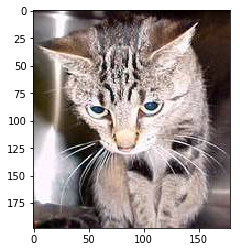

In [7]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [8]:
img.shape

(198, 179, 3)

In [9]:
img[:4,:4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

### Test the proper learning rate:
Determines how quickly to update the weights on each neuron.  Significant impact on the model's performance if it's outside a reasonable band.  Decent technique is to start from a very small value, measure the loss, and increase the learning rate iteratively until we find a point where the loss starts to increase.  The idea is to identify the quickest learning rate that doesn't negatively impact the model's performance.

Mathematically, the learning rate is multiplied by the gradient (derivative) of the loss function at any given point.

In [4]:
%%time
sz = 200
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(resnet34, sz))
learn = ConvLearner.pretrained(resnet34, data, precompute=True)
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.050008   0.027104   0.989746  

CPU times: user 9.57 s, sys: 6.2 s, total: 15.8 s
Wall time: 14.5 s


In [6]:
lrf = learn.lr_find()

 76%|███████▌  | 272/360 [00:04<00:01, 55.03it/s, loss=0.166] 


### Look at what the model's doing:

In [7]:
# Labels for the validation dataset
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [8]:
# cats is 0 and dogs is 1
data.classes

['cats', 'dogs']

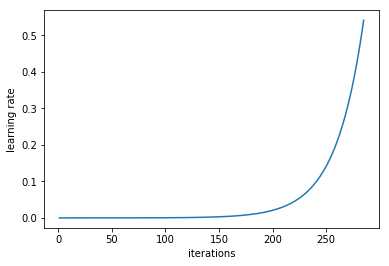

In [9]:
# Tests mini-batches of the data to find a proper learning rate, which we can 
# then plot:
learn.sched.plot_lr()

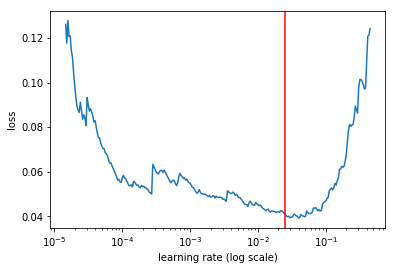

In [10]:
import matplotlib.pyplot as plt
learn.sched.plot()
plt.axvline(x=2.5e-2, color="red");

### Analyze Results:
1. Some correct labels at random
2. Incorrect labels at random
3. Most correct labels for each class (i.e. the easiest to classify)
4. Most incorrect for each class (i.e. where the model is simply off)
5. Closest to 0.5 predictions (i.e. the most uncertain predictions)

In [11]:
log_preds = learn.predict() # make predictions for validation data
log_preds.shape

(2000, 2)

In [12]:
log_preds[:10]

array([[ -0.     , -12.88907],
       [ -0.00229,  -6.07832],
       [ -0.00015,  -8.83198],
       [ -0.00175,  -6.34721],
       [ -0.00025,  -8.28933],
       [ -0.00361,  -5.62472],
       [ -0.00009,  -9.32537],
       [ -0.00001, -11.46402],
       [ -0.00138,  -6.58816],
       [ -0.00021,  -8.48833]], dtype=float32)

Note that the probabilities shown above are given on the log scale

In [13]:
preds = np.argmax(log_preds, axis=1) # 0/1 predictions
probs = np.exp(log_preds[:, 1]) # probability(dog)

In [14]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [15]:
def plot_vals_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [16]:
def plots(ims, figsize=(12, 6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [17]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correct Predictions


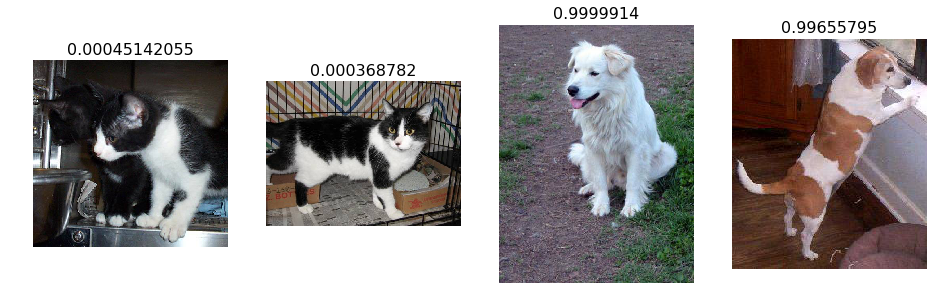

In [18]:
plot_val_with_title(rand_by_correct(True), "Correct Predictions")

Incorrect Predictions


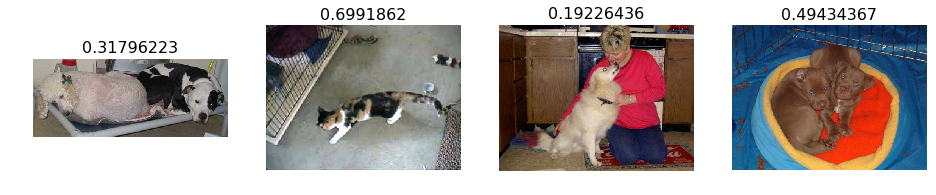

In [19]:
plot_val_with_title(rand_by_correct(False), "Incorrect Predictions")

In [21]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most correct cats


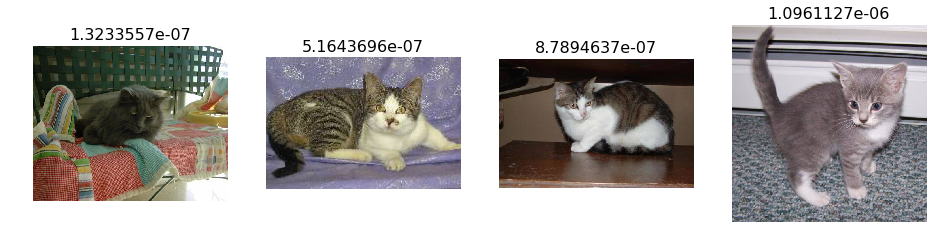

In [22]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


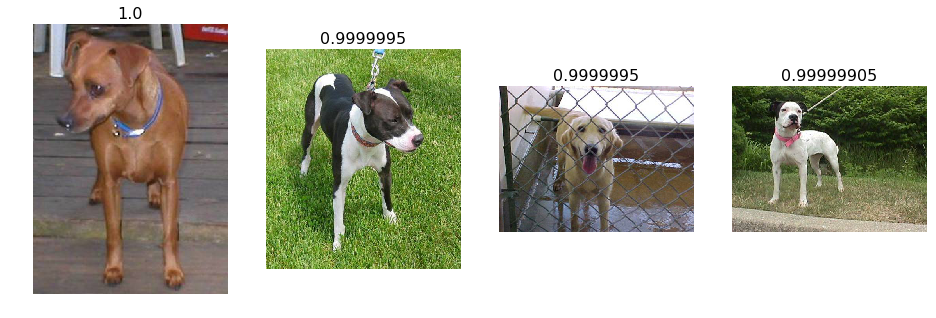

In [23]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


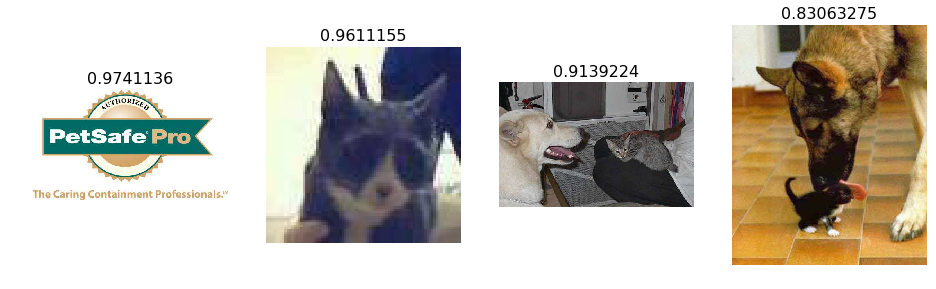

In [24]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


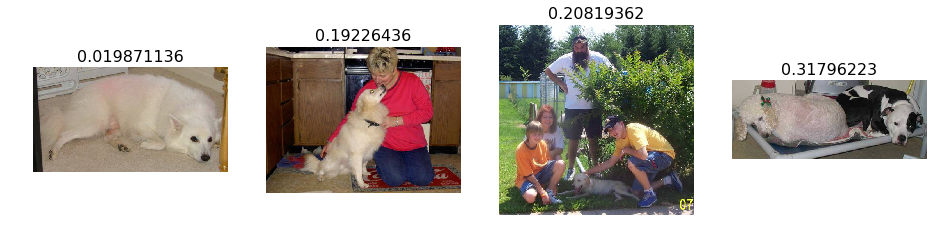

In [25]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


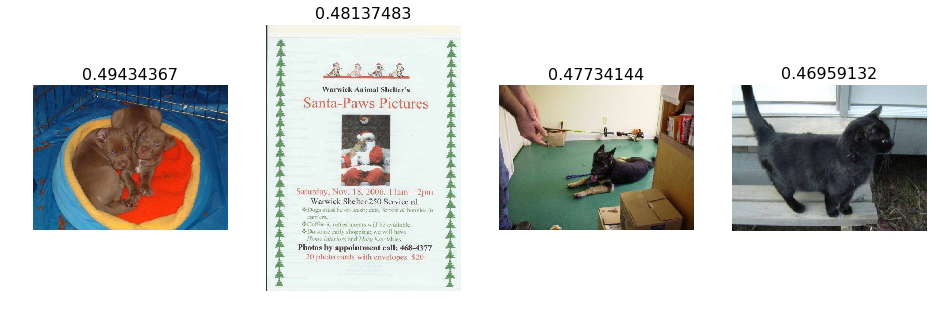

In [26]:
most_uncertain = np.argsort(np.abs(probs - 0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

### Improving the model
#### Data augmentation

Training for more epochs tends to cause overfitting, meaning in this case that the model starts to 'memorize' the specific images in the training set instead of generalizing properly to apply what it's learned to the validation set.  Creating more data (data augmentation) is done way to address this.  We can do this e.g. by flipping the images, rotating them, zooming in, etc - operations that shouldn't affect their interpretation. 

pass the `aug_tfms` parameter to `tfms_from_model` to do this.  `transforms_side_on` is a pre-defined list of functions for photos like the ones we have (taken from the side as opposed to top-down or some other angle).  `max_zoom` lets us specify random zooming of the images.

In [27]:
tfms = tfms_from_model(resnet34, sz, 
                       aug_tfms=transforms_side_on, 
                       max_zoom=1.1)

In [28]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [29]:
ims = np.stack([get_augs() for i in range(6)])

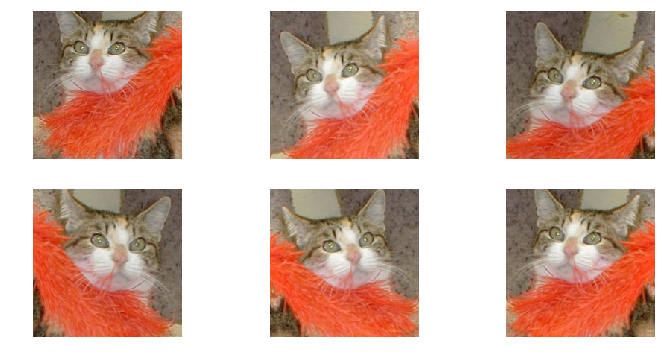

In [30]:
plots(ims, rows=2)

Make a new `data` object that includes augmented images in the transforms

In [31]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [32]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.062013   0.036057   0.986816  



[0.036056643788469955, 0.98681640625]

In [33]:
learn.precompute=False

In [34]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.056188   0.029307   0.987305  
    1      0.045613   0.028466   0.990234                     
    2      0.046009   0.027124   0.987793                     



[0.027124340238515288, 0.98779296875]

#### Explanation of the above code:
`cycle_len` is used in *stochastic gradient descent with restarts*, which is a variant of *learning rate annealing*, in which we gradually decrease the learning rate as training progresses.  Helps because we want to take smaller steps as we hone in on the optimal learning rate. The `cycle_len` parameter controls the number of epochs between resetting the learning rate.

One potential issue is that portions of the weight space may be such that small changes in the weights cause large changes to the loss.  A good goal is to encourage models to find portions of the weight space that are more *resilient*.  SGDR periodically forces the model to jump to different portions of the weight space in order to accomplish this.

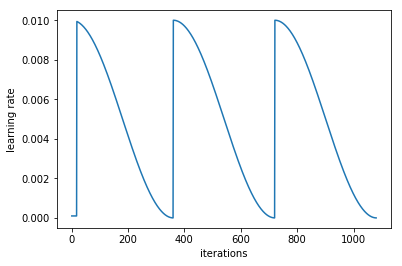

In [35]:
learn.sched.plot_lr()

In [36]:
# save the model since we're getting pretty decent results:
learn.save('200_lastlayer')

In [37]:
learn.load('200_lastlayer')

### Fine-tuning and differential learning rate annealing
Used to adjust the other layers in the model now that a good final layer has been created.

In [38]:
learn.unfreeze()

The other layers were *already* trained to identify imagenet photos (while the final layers were randomly initialized), so be careful not to destroy the weights that were already tuned there.

The earlier layers tend to have more general-purpose features.  So, they don't need as much fine-tuning for new datasets.  This means that we can use different learning rates for different layers.  Set the first few layers at 1e-4, the middle at 1e-3 and the FC layers at 1e-2 as done above.

In [39]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [40]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.054143   0.025782   0.991699  
    1      0.050173   0.026886   0.990723                     
    2      0.033356   0.027701   0.98877                      
    3      0.032465   0.028658   0.989258                     
    4      0.024773   0.032325   0.986816                     
    5      0.021528   0.029052   0.990234                     
    6      0.016247   0.029215   0.989746                     



[0.029214652589871548, 0.98974609375]

Note that `cycle_mult = 2` used above doubles the length of each cycle

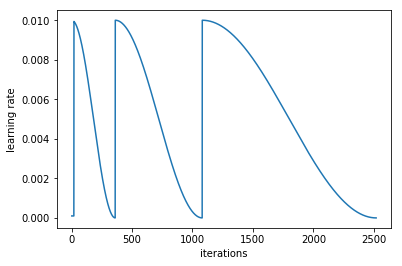

In [41]:
learn.sched.plot_lr()

The above is a plot of the learning rate of the *final layers*.  The learning rates of the earlier layers are fixed at the same multiples of the final layer rates that were initially requested (i.e. the first layers have 100x smaller and middle layers 10x smaller learning rates)

In [42]:
learn.save('200_all')

In [43]:
learn.load('200_all')

Another application of data augmentation is to use it at *inference time*, called *test time augmentation*.  This makes predictions on the images in the validation set but *also* on a number of randomly augmented versions of them, and then averages those predictions together.

In [92]:
log_preds, y = learn.TTA()

In [93]:
log_preds_avg = log_preds.mean(axis=(0))

In [99]:
preds = np.argmax(log_preds_avg, axis=1)

In [104]:
(preds == y).mean()

0.99

## Analyzing Results

In [107]:
probs = np.exp(log_preds_avg[:,1])

[[990  10]
 [ 10 990]]


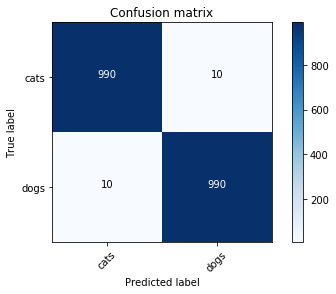

In [109]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

Most incorrect cats


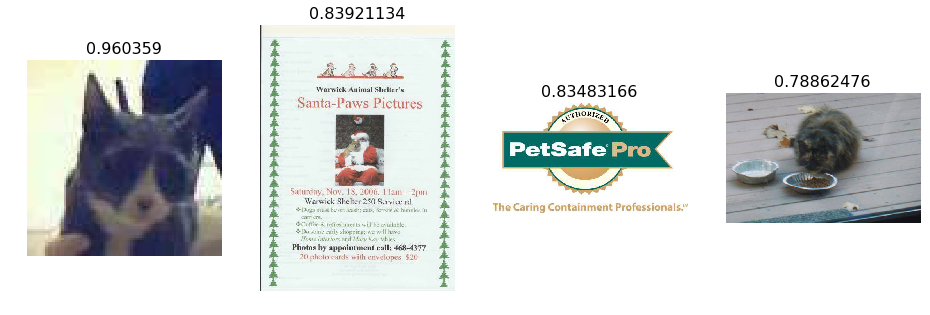

In [111]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


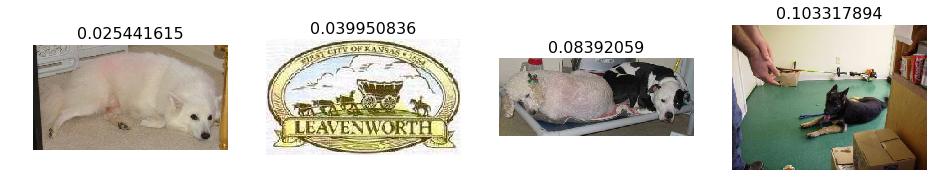

In [113]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")